In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.notebook import tqdm as tq
from time import sleep
from IPython.display import clear_output, display

In [1]:
class SSAmodel():
    '''compartment based reaction-diffusion model'''
    def __init__(self, surface, species_init, reacprops, reactions):
        # surface parameters
        for key,val in surface.items():
            setattr(self, key, val)
        self.delta = self.D / (self.length/self.bins)**2
        self.reacprops = reacprops
        self.reactions = reactions
 
        # initialize a surface matrix for each species
        self.matrices = {}
        for spec, particles in species_init.items():
            if particles < self.bins**2:
                matrix = np.full((self.bins**2),0)
                matrix[:particles] = 1
                np.random.shuffle(matrix)
                matrix.shape = (self.bins, self.bins)
                self.matrices[spec] = matrix
            else:
                self.matrices[spec] = np.full((self.bins, self.bins), particles // self.bins**2)
        
        # initialize time
        self.time = 0


    def simulate(self, maxstep, savedata=False, simlive=False):
        # initialize dict for memory
        self.data = {}
        self.times = []
        for spec in self.matrices.keys():
            self.data[spec] = []

        for _ in range(maxstep):
            # 1. generate random uniform variables: r1, r2
            r1, r2 = np.random.uniform(size=2)

            # 2. calculate diff propensity matrix for each species, each cell is diff prop for bin i,j
            self.diffmatrices = {}
            for item in self.matrices.items():
                species, matrix = item
                diffmatrix = matrix * self.delta
                self.diffmatrices[species] = diffmatrix
            
            # 3. calculate react propensity matrix for each reaction, each cell is reaction prop for bin i,j
            self.reactmatrices = {}
            for item in self.reacprops.items():
                key, lambprop = item
                reactID, specs = key
                if type(specs) != str:
                    particlematrices = [self.matrices[spec] for spec in specs]
                    reactmatrix = lambprop(*particlematrices) 
                else:
                    reactmatrix = lambprop(self.matrices[specs])
                self.reactmatrices[reactID] = reactmatrix
            
            # 4. get sum of propensities (a0)
            directions = {
                'up': lambda matrix: matrix[1:,:],
                'down': lambda matrix: matrix[:-1,:],
                'left': lambda matrix: matrix[:,1:],
                'right': lambda matrix: matrix[:,:-1]
                }
            
            # 4.1 sum a_i for all possible diffusion directions
            alpha_diff = 0
            for matrix in self.diffmatrices.values():
                for lamb in directions.values():
                    alpha_diff += lamb(matrix).sum()
            
            # 4.2 sum a_i for all for all compartment reactions
            alpha_react = 0
            for matrix in self.reactmatrices.values():
                alpha_react += matrix.sum()
            
            # 4.3 sum reaction and diffusion propensities (a0)
            self.a0 = alpha_diff + alpha_react
            self.alpha_react = alpha_react
            self.alpha_diff = alpha_diff

            # 5. add tauleap to time
            self.time += (1/self.a0) * np.log(1/r1)

            # 6. choose chemical reaction or diffusion
            if r2 < alpha_react / self.a0:
                self.choice = 'reaction'

                # choose which reaction
                a_sum = 0
                for reactID, matrix in self.reactmatrices.items():
                    if a_sum <= r2 < a_sum + (matrix.sum()/self.a0):
                        self.reaction = reactID
                        break
                    else:
                        a_sum += (matrix.sum()/self.a0)

                # choose which compartment
                for i in range(self.bins):
                    for j in range(self.bins):
                        if a_sum <= r2 < a_sum + (matrix[i][j]/self.a0):
                            self.cell = (i, j)
                            break
                        else:
                            a_sum += (matrix[i][j]/self.a0)
                    else:
                        continue
                    break

                # update matrices according to reaction
                spec_updates = self.reactions[self.reaction]
                for spec, matrix in self.matrices.items():
                    update = spec_updates[spec]
                    matrix[self.cell[0]][self.cell[1]] += update
                    self.matrices[spec] = matrix


            else:
                self.choice = 'diffusion'

                # choose which surface and direction
                a_sum = alpha_react / self.a0
                for specID, matrix in self.diffmatrices.items():
                    for direction, lamb in directions.items():
                        if a_sum <= r2 < a_sum + (lamb(matrix).sum()/self.a0):
                            self.diffusion = (specID, direction)
                            break
                        else:
                            a_sum += (lamb(matrix).sum()/self.a0)
                    else:
                        continue
                    break
                
                # choose compartment
                imin = jmin = 0
                imax = jmax = self.bins
                if self.diffusion[1] == 'up':
                    imin += 1
                elif self.diffusion[1] == 'down':
                    imax -= 1
                elif self.diffusion[1] == 'left':
                    jmin += 1
                elif self.diffusion[1] == 'right':
                    jmax -= 1
                
                for i in range(imin, imax):
                    for j in range(jmin, jmax):
                        if a_sum <= r2 < a_sum + (matrix[i][j]/self.a0):
                            self.cell = (i, j)
                            break
                        else:
                            a_sum += (matrix[i][j]/self.a0)
                    else:
                        continue
                    break

                # transfer particle from compartment to adjacent compartment according to direction
                i, j = self.cell
                matrix = self.matrices[self.diffusion[0]]
                matrix[i][j] -= 1
                if self.diffusion[1] == 'up':
                    matrix[i-1][j] += 1
                elif self.diffusion[1] == 'down':
                    matrix[i+1][j] += 1
                elif self.diffusion[1] == 'left':
                    matrix[i][j-1] += 1
                elif self.diffusion[1] == 'right':
                    matrix[i][j+1] += 1
                
                self.matrices[self.diffusion[0]] = matrix

            # save data if save is True
            if savedata:
                for spec, matrix in self.matrices.items():
                    self.data[spec].append(matrix.sum())
                self.times.append(self.time)
            
            # simulate and plot live
            if simlive:
                self.plotsimlive()
    

    def plotsimlive(self):
        '''plots surface matrices live of each species during simulation'''

        fig, axs = plt.subplots(1, len(self.matrices.keys()), figsize=[15,5])    
        for ax, label in zip(axs, self.matrices.keys()): 
            clear_output(wait=True)
            ax.imshow(sim.matrices[label], vmin=0, vmax=8)
            ax.axis('off')
            ax.set_title(f"{label}, total: {sim.matrices[label].sum()}")
        # if self.choice == 'reaction':
        #     plt.title(f"{self.choice}: {self.cell}, {self.reaction}")
        # elif self.choice == 'diffusion':
        #     plt.title(f"{self.choice}: {self.cell}, {self.diffusion}")
        plt.show()


    def plotsim(self):
        '''plots saved simulated data from instance'''
        plt.figure(figsize=[10,5])
        for spec, pnum in self.data.items():
            plt.plot(self.times, pnum, label = spec)
        plt.xlabel('time')
        plt.ylabel('particles')
        plt.legend()
        plt.show()

    
def steady(SSAmodel, reps, maxstep):
    '''simulates steady state of system'''
    pass


def convert(Kd_3D, koff_3D):
    '''convert 3D rate constants to 2D rate constants, with micrometer as length unit'''
    pass

* boxsize = 73x73 um
* avg diffusion coeff = 0.75 um2/s

In [2]:
# dict with params for 2D diffusion surface, distance units in micrometers
surface = {
    'bins' : 10,
    'length' : 73,
    'D' : 0.75,
    }

# initialize species
species_init = {
    'f': 500,
    'a': 250,
    'fa': 0,
    'faf': 0
}

# dict with reaction propensities, based on prev. kinetic studies with FKBP
reacprops = {
    (1, ('f', 'a')) : lambda f, a : f*a*00.33214,
    (2, ('fa')) : lambda fa : fa*0.0015,
    (3, ('f', 'fa')) : lambda f,fa : fa*f*0.2,
    (4, ('faf')) : lambda faf : faf*0.022
}

# reaction outcomes
reactions = {
    1 : {'f':-1, 'a':-1, 'fa':1, 'faf':0},
    2 : {'f':1, 'a':1, 'fa':-1, 'faf':0},
    3 : {'f':-1, 'a':0, 'fa':-1, 'faf':1},
    4 : {'f':1, 'a':0, 'fa':1, 'faf':-1}
}

In [33]:
sim = SSAmodel(surface, species_init, reacprops, reactions)

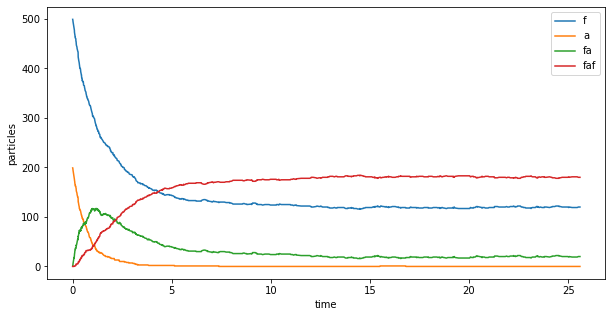

In [5]:
sim.simulate(1000, savedata=True)
sim.plotsim()

In [48]:
from time import sleep
FA_ss = []
FAF_ss = []
as_ = []

# get steady states
for a in tq(range(0, 1000, 2)):
    species_init = {
        'f': 500,
        'a': a,
        'fa': 0,
        'faf': 0}
    
    sim = SSAmodel(surface, species_init, reacprops, reactions)
    sim.simulate(1500, savedata=True)
    FA_ss.append(np.mean(sim.data['fa'][1450:])) 
    FAF_ss.append(np.mean(sim.data['faf'][1450:]))
    as_.append(a)
    sleep(0.1)

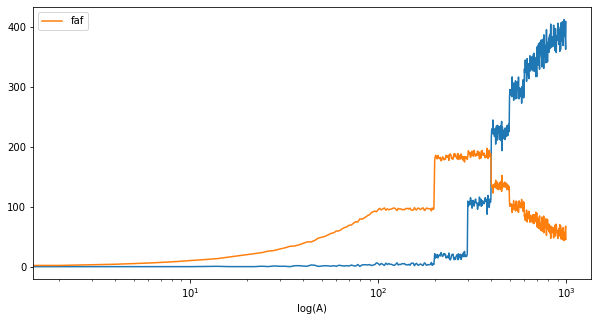

In [51]:
plt.figure(figsize=[10,5])
plt.plot(as_, FA_ss, '-')
plt.plot(as_, FAF_ss, '-', label='faf')
plt.xlabel('log(A)')
plt.xscale('log')
plt.legend()
plt.show()